# Import library

In [1]:
import os
import sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
pd.set_option("display.max_column", 100)
pd.set_option("display.max_row", 100)

In [3]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

# Data load

In [4]:
bucket_name = 'shine_v3_7_kt'
df_all = pd.read_csv(f"../pipeline/output/{bucket_name}/df_all_added_owid.csv")

In [5]:
size_and_ratio(df_all, 'pcr_result')

Sum : 30273 (2,)


,size,ratio
pcr_result,,
1,18131,0.598917
0,12142,0.401083


In [6]:
size_and_ratio(df_all, 'split')

Sum : 30273 (3,)


,size,ratio
split,,
TRAIN,18245,0.602682
TEST,6252,0.206521
VALIDATE,5776,0.190797


In [7]:
df_all[df_all['patient_id'] == 30888]

,patient_id,selfcheck_date,pcr_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,sigungu_confirmed_mask,indication_other,indication_abroad,indication_contact,gender,age_ratio,age_60_and_above,smoking,hx_covid_result,hx_covid_date,weekday,selfcheck_reason,scReason1,scReason2,scReason3,scReason4,scReason5,scReason6,scReason7,scReason8,scReason9,scReason10,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask,total_cases_per_million_for_6months_norm,total_cases_per_million_for_6months_mask,total_vaccinations_per_hundred_for_6months_norm,total_vaccinations_per_hundred_for_6months_mask,total_deaths_per_million_for_6months_norm,total_deaths_per_million_for_6months_mask,positive_rate_norm,positive_rate_mask,reproduction_rate_norm,reproduction_rate_mask
798,30888,2022-03-04,2022-02-28,1,0,0,0,0,0,0,0,0,0,0,0,1.073988,2.073168,0.076653,0,1,0,0,1.0,0.55,0.0,0,0,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,TRAIN,KOR,2022-03-04,0.111952,0.0,0.021444,0.0,0.102263,0.0,0.026331,0.0,0.006906,0.0,0.016711,0.0,0.085131,0.0,0.000000,1.0,0.0,1.0,0.329975,0.0,0.040748,0.0,0.031652,0.0,0.096766,0.0,0.568216,0.0,0.666538,0.0,0.670817,0.0,0.408321,0.0,0.014362,0.0,0.000427,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.2666,0.0,0.250426,0.0
1792,30888,2022-03-10,2022-03-10,1,0,0,0,0,0,0,0,0,0,0,0,1.248952,4.220764,0.125279,0,1,0,0,1.0,0.55,0.0,2,0,NaN,3,4,0,0,0,1,0,0,0,0,0,0,0,TRAIN,KOR,2022-03-10,0.154738,0.0,0.023861,0.0,0.138014,0.0,0.029562,0.0,0.007322,0.0,0.024018,0.0,0.118888,0.0,0.000000,1.0,0.0,1.0,0.352047,0.0,0.043451,0.0,0.023376,0.0,0.102390,0.0,0.569791,0.0,0.666847,0.0,0.671211,0.0,0.411909,0.0,0.010784,0.0,0.000598,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.3400,0.0,0.231687,0.0
2263,30888,2022-03-12,2022-03-10,1,0,1,0,1,0,0,0,0,0,0,0,1.248952,4.220764,0.125279,0,1,0,0,1.0,0.55,0.0,2,0,NaN,3,8,0,0,0,0,0,0,0,1,0,0,0,TRAIN,KOR,2022-03-12,0.174239,0.0,0.029527,0.0,0.155476,0.0,0.031118,0.0,0.008024,0.0,0.026675,0.0,0.113867,0.0,0.000000,1.0,0.0,1.0,0.358643,0.0,0.044706,0.0,0.035881,0.0,0.110486,0.0,0.570603,0.0,0.667002,0.0,0.671448,0.0,0.413704,0.0,0.010349,0.0,0.000769,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.3550,0.0,0.243612,0.0
8990,30888,2022-04-06,2022-04-06,1,0,0,0,0,0,0,0,0,0,0,1,0.814378,3.352451,0.296869,0,1,0,0,1.0,0.55,0.0,2,0,NaN,2,1,1,0,0,0,0,0,0,0,0,0,0,TRAIN,KOR,2022-04-06,0.392740,0.0,0.018954,0.0,0.124579,0.0,0.055025,0.0,

In [8]:
# baby_id 하나에 여러케이스 있는 경우 체크
df_negative = df_all[df_all['pcr_result'] == 0]
sample = df_negative['patient_id'].sample(15)
for p_id in sample:
    print(p_id, df_negative[df_negative['patient_id'] == p_id].shape)

41180 (2, 96)
44308 (1, 96)
41571 (2, 96)
32938 (9, 96)
62256 (6, 96)
51395 (20, 96)
29234 (49, 96)
64700 (4, 96)
29206 (6, 96)
49232 (2, 96)
39805 (5, 96)
53889 (57, 96)
48746 (4, 96)
26848 (48, 96)
49994 (4, 96)


In [9]:
df_all[df_all['pcr_result'] == 0].sample(10)

,patient_id,selfcheck_date,pcr_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,sigungu_confirmed_mask,indication_other,indication_abroad,indication_contact,gender,age_ratio,age_60_and_above,smoking,hx_covid_result,hx_covid_date,weekday,selfcheck_reason,scReason1,scReason2,scReason3,scReason4,scReason5,scReason6,scReason7,scReason8,scReason9,scReason10,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask,total_cases_per_million_for_6months_norm,total_cases_per_million_for_6months_mask,total_vaccinations_per_hundred_for_6months_norm,total_vaccinations_per_hundred_for_6months_mask,total_deaths_per_million_for_6months_norm,total_deaths_per_million_for_6months_mask,positive_rate_norm,positive_rate_mask,reproduction_rate_norm,reproduction_rate_mask
20578,28963,2022-03-29,2022-03-28,0,0,0,0,0,0,0,0,0,0,0,0,1.231139,5.181301,0.252722,0,1,0,0,1.0,0.61,1.0,0,0,NaN,0,8,0,0,0,0,0,0,0,1,0,0,0,VALIDATE,KOR,2022-03-29,0.339497,0.0,0.035801,0.0,0.173797,0.0,0.047463,0.0,0.013811,0.0,0.044940,0.0,0.129780,0.0,0.000000,1.0,0.00000,1.0,0.341502,0.0,0.050615,0.0,0.025334,0.0,0.067451,0.0,0.574392,0.0,0.667545,0.0,0.672078,0.0,0.423008,0.0,0.007232,0.0,0.000256,0.0,0.88913,0.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.6499,0.0,0.158433,0.0
25851,44065,2022-03-23,2022-03-15,0,0,0,0,0,0,0,0,0,0,0,0,1.207845,5.977065,0.149970,0,1,0,0,0.0,0.56,0.0,0,0,NaN,1,1,1,0,0,0,0,0,0,0,0,0,0,TEST,KOR,2022-03-23,0.287617,0.0,0.033348,0.0,0.190415,0.0,0.041617,0.0,0.015027,0.0,0.044907,0.0,0.115788,0.0,0.000000,1.0,0.00000,1.0,0.336732,0.0,0.048851,0.0,0.021873,0.0,0.075947,0.0,0.573161,0.0,0.667390,0.0,0.671842,0.0,0.419951,0.0,0.008428,0.0,0.000342,0.0,0.88913,0.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.6324,0.0,0.168654,0.0
21649,49497,2022-04-12,2022-04-08,1,0,0,0,0,0,0,0,0,0,0,0,0.783955,2.766774,0.000000,1,1,0,0,1.0,0.39,0.0,0,0,NaN,4,8,0,0,0,0,0,0,0,1,0,0,0,VALIDATE,KOR,2022-04-12,0.420704,0.0,0.016476,0.0,0.094539,0.0,0.059973,0.0,0.005882,0.0,0.037116,0.0,0.107353,0.0,0.000000,1.0,0.07343,0.0,0.263157,0.0,0.053515,0.0,0.015318,0.0,0.040121,0.0,0.576237,0.0,0.668242,0.0,0.672551,0.0,0.426995,0.0,0.003766,0.0,0.000427,0.0,0.88913,0.0,0.000000,1.0,0.421228,0.0,0.0,1.0,0.000000,1.0,0.5943,0.0,0.117547,0.0
3712,39521,2022-03-17,2022-03-14,1,0,0,0,1,0,0,0,0,0,0,0,1.333682,5.404349,0.113153,0,1,0,0,1.0,0.37,0.0,0,0,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,TRAIN,KOR,2022-03-17,0.230079,0.0,0.0

## Compare hx_covid vs pcr_result

In [10]:
def is_similar(a, b, threshold=14):
    try:
        a_date = datetime.strptime(a, '%Y-%m-%d')
        b_date = datetime.strptime(b, '%Y-%m-%d')
    except:
        return False
    th_date = timedelta(days=threshold)
    return a_date - th_date <= b_date and b_date - th_date <= a_date
assert is_similar("2020-01-01", '2020-01-01')
assert not is_similar("2020-01-01", '2020-01-16')
assert not is_similar("2020-01-16", '2020-01-01')
assert is_similar("2020-01-01", '2020-01-15')
assert is_similar("2020-01-15", '2020-01-15')
assert is_similar("2020-12-20", '2021-01-01')
assert not is_similar("2021-01-01", '2021-12-31')
assert not is_similar("2021-01-16", '2020-12-30')

In [11]:
# df_all['hx_covid_result'].astype(bool)
    
df_all['hx_covid_date_recent'] = df_all.apply(lambda x: is_similar(x.hx_covid_date, x.pcr_date), axis=1)
df_all[['hx_covid_date', 'pcr_date', 'hx_covid_date_recent', ]].sample(15)

,hx_covid_date,pcr_date,hx_covid_date_recent
27916,NaN,2022-04-27,False
27018,2022-04-01,2022-04-01,True
3316,2022-03-07,2022-03-06,True
26137,NaN,2022-03-17,False
13045,NaN,2022-06-23,False
17153,NaN,2022-12-25,False
22507,2022-03-05,2022-06-28,False
19453,2022-03-17,2022-03-17,True
15259,2022-04-15,2022-09-19,False
11200,NaN,2022-04-20,False


In [12]:
size_and_ratio(df_all, ['hx_covid_date_recent', 'pcr_result']).sort_index()

Sum : 30273 (4,)


size     ratio
hx_covid_date_recent pcr_result                 
False                0           11978  0.395666
                     1            6510  0.215043
True                 0             164  0.005417
                     1           11621  0.383873

In [13]:
df_selfcheck_later = df_all[df_all['pcr_date'] < df_all['selfcheck_date']]
size_and_ratio(df_selfcheck_later, ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 20706 (4,)


size     ratio
pcr_result hx_covid_date_recent                 
0          False                  6787  0.327779
           True                    132  0.006375
1          False                  3216  0.155317
           True                  10571  0.510528

In [ ]:
# 1. pcr이후 selfcheck만 남김
# 2. pcr이후 selfcheck중에 hx_coivd_date pcr_date에 가까운게 있으면 True 없으면 False
# pcr + 중에 2번에서 True 나온사람의 비율

In [14]:

size_and_ratio(df_selfcheck_later[df_selfcheck_later['pcr_result'] == 1], ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 13787 (2,)


size     ratio
pcr_result hx_covid_date_recent                 
1          False                  3216  0.233263
           True                  10571  0.766737

In [15]:
size_and_ratio(df_selfcheck_later[df_selfcheck_later['hx_covid_date_recent'] == True], ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 10703 (2,)


,,size,ratio
pcr_result,hx_covid_date_recent,,
0,True,132,0.012333
1,True,10571,0.987667


# 모델 결과 로드

In [30]:
dir_result = "../mc_scripts/model/train_result/"

all_results = dict()
result_dirs = sorted(os.listdir(dir_result))
# display(result_dirs)
for train_name in result_dirs:
    
    if not os.path.isdir(os.path.join(dir_result, train_name)):
        continue
    
    if not 'v16' in train_name:
        continue
        
    df_result = pd.read_csv(os.path.join(dir_result, train_name, "result.csv"))
    print(train_name)
    display(df_result)
    all_results[train_name] = df_result

v16_20230424_185134_patient+screason_manual_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.774079,0.773820,0.774096,0.774169,0.775769,0.774386,0.000640
1,XGBoost,0.784074,0.784074,0.784074,0.784074,0.784074,0.784074,0.000000
2,LGBM,0.784471,0.784471,0.784471,0.784471,0.784471,0.784471,0.000000
3,TabNet,0.766829,0.780004,0.773943,0.777130,0.782109,0.776003,0.004881


v16_20230424_185134_patient_manual


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.857952,0.857554,0.858242,0.858107,0.857290,0.857829,3.237297e-04
1,XGBoost,0.860411,0.860411,0.860411,0.860411,0.860411,0.860411,4.532467e-17
2,LGBM,0.859560,0.859560,0.859560,0.859560,0.859560,0.859560,0.000000e+00
3,TabNet,0.859612,0.862890,0.862274,0.859761,0.862185,0.861344,1.256225e-03


v16_20230424_214954_patient+screason+gps_manual_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.777250,0.776920,0.777579,0.777811,0.777557,0.777423,0.000281
1,XGBoost,0.781696,0.781696,0.781696,0.781696,0.781696,0.781696,0.000000
2,LGBM,0.788231,0.788231,0.788231,0.788231,0.788231,0.788231,0.000000
3,TabNet,0.771936,0.786216,0.771395,0.770770,0.768897,0.773843,0.005725


v16_20230424_220022_patient+screason+si10_manual_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.836133,0.835932,0.836458,0.838989,0.838379,0.837178,1.146384e-03
1,XGBoost,0.842619,0.842619,0.842619,0.842619,0.842619,0.842619,4.532467e-17
2,LGBM,0.844018,0.844018,0.844018,0.844018,0.844018,0.844018,0.000000e+00
3,TabNet,0.821511,0.830513,0.826709,0.836273,0.821514,0.827304,5.134420e-03


v16_20230424_221040_patient+screason+hw7_manual_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.831974,0.831433,0.832242,0.834257,0.834606,0.832902,1.168741e-03
1,XGBoost,0.830484,0.830484,0.830484,0.830484,0.830484,0.830484,4.532467e-17
2,LGBM,0.841984,0.841984,0.841984,0.841984,0.841984,0.841984,0.000000e+00
3,TabNet,0.815295,0.817128,0.808542,0.809522,0.811307,0.812359,3.029960e-03


v16_20230424_221117_patient+gps_manual


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.865676,0.865710,0.866320,0.865928,0.865516,0.865830,0.000254
1,XGBoost,0.880715,0.880715,0.880715,0.880715,0.880715,0.880715,0.000000
2,LGBM,0.882293,0.882293,0.882293,0.882293,0.882293,0.882293,0.000000
3,TabNet,0.869532,0.874895,0.872991,0.875722,0.874883,0.873605,0.002031


v16_20230424_222832_patient+screason+owid_manual_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.833351,0.832743,0.834171,0.835358,0.834997,0.834124,8.935807e-04
1,XGBoost,0.827978,0.827978,0.827978,0.827978,0.827978,0.827978,1.110223e-16
2,LGBM,0.834421,0.834421,0.834421,0.834421,0.834421,0.834421,0.000000e+00
3,TabNet,0.808415,0.826742,0.813893,0.819184,0.825065,0.818660,6.248821e-03


v16_20230425_073332_patient+si10_manual


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.891246,0.891116,0.891205,0.890944,0.890980,0.891098,1.089586e-04
1,XGBoost,0.894287,0.894287,0.894287,0.894287,0.894287,0.894287,4.532467e-17
2,LGBM,0.897963,0.897963,0.897963,0.897963,0.897963,0.897963,0.000000e+00
3,TabNet,0.891065,0.890913,0.886083,0.893231,0.891177,0.890494,2.156936e-03


v16_20230425_073418_patient+screason+gps+si10+owid_manual_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.830410,0.829639,0.832162,0.831281,0.830778,0.830854,7.715766e-04
1,XGBoost,0.829432,0.829432,0.829432,0.829432,0.829432,0.829432,0.000000e+00
2,LGBM,0.840272,0.840272,0.840272,0.840272,0.840272,0.840272,4.532467e-17
3,TabNet,0.828777,0.798985,0.797756,0.799830,0.816772,0.808424,1.125999e-02


v16_20230425_075254_patient+screason+gps+bts_manual_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.773344,0.772385,0.774313,0.773269,0.772624,0.773187,6.137330e-04
1,XGBoost,0.783592,0.783592,0.783592,0.783592,0.783592,0.783592,1.110223e-16
2,LGBM,0.785245,0.785245,0.785245,0.785245,0.785245,0.785245,1.110223e-16
3,TabNet,0.774574,0.765791,0.774966,0.765449,0.776844,0.771525,4.457697e-03


v16_20230425_080155_patient+hw7_manual


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.890047,0.890065,0.889944,0.889697,0.889766,0.889904,1.354167e-04
1,XGBoost,0.893945,0.893945,0.893945,0.893945,0.893945,0.893945,0.000000e+00
2,LGBM,0.897177,0.897177,0.897177,0.897177,0.897177,0.897177,1.110223e-16
3,TabNet,0.887965,0.887467,0.890808,0.893002,0.885419,0.888932,2.432527e-03


v16_20230425_081029_patient+screason+gps+bts+si10+owid_manual_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.827764,0.825736,0.830626,0.827913,0.826587,0.827725,0.001511
1,XGBoost,0.829582,0.829582,0.829582,0.829582,0.829582,0.829582,0.000000
2,LGBM,0.840552,0.840552,0.840552,0.840552,0.840552,0.840552,0.000000
3,TabNet,0.827736,0.779390,0.805539,0.796106,0.807334,0.803221,0.014386


v16_20230425_083146_patient+owid_manual


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.891521,0.891455,0.891528,0.891348,0.891252,0.891421,9.700878e-05
1,XGBoost,0.893136,0.893136,0.893136,0.893136,0.893136,0.893136,1.110223e-16
2,LGBM,0.896402,0.896402,0.896402,0.896402,0.896402,0.896402,0.000000e+00
3,TabNet,0.891852,0.891332,0.891362,0.891547,0.893385,0.891896,7.005192e-04


v16_20230425_093911_patient+gps+si10+owid_manual


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.892551,0.892807,0.892967,0.892379,0.892121,0.892565,2.744658e-04
1,XGBoost,0.900348,0.900348,0.900348,0.900348,0.900348,0.900348,0.000000e+00
2,LGBM,0.907030,0.907030,0.907030,0.907030,0.907030,0.907030,1.110223e-16


In [31]:
df_result_all = pd.DataFrame()

for train_name, df_result in all_results.items():
    df_result = df_result.rename(columns={'Unnamed: 0': 'structure'})
    df_result['train_name'] = train_name
    df_result_all = df_result_all.append(df_result)
    print(train_name, df_result.shape, df_result_all.shape)

df_result_all

v16_20230424_185134_patient+screason_manual_onlyscfirstTrue (4, 9) (4, 9)
v16_20230424_185134_patient_manual (4, 9) (8, 9)
v16_20230424_214954_patient+screason+gps_manual_onlyscfirstTrue (4, 9) (12, 9)
v16_20230424_220022_patient+screason+si10_manual_onlyscfirstTrue (4, 9) (16, 9)
v16_20230424_221040_patient+screason+hw7_manual_onlyscfirstTrue (4, 9) (20, 9)
v16_20230424_221117_patient+gps_manual (4, 9) (24, 9)
v16_20230424_222832_patient+screason+owid_manual_onlyscfirstTrue (4, 9) (28, 9)
v16_20230425_073332_patient+si10_manual (4, 9) (32, 9)
v16_20230425_073418_patient+screason+gps+si10+owid_manual_onlyscfirstTrue (4, 9) (36, 9)
v16_20230425_075254_patient+screason+gps+bts_manual_onlyscfirstTrue (4, 9) (40, 9)
v16_20230425_080155_patient+hw7_manual (4, 9) (44, 9)
v16_20230425_081029_patient+screason+gps+bts+si10+owid_manual_onlyscfirstTrue (4, 9) (48, 9)
v16_20230425_083146_patient+owid_manual (4, 9) (52, 9)
v16_20230425_093911_patient+gps+si10+owid_manual (3, 9) (55, 9)


/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_30016/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_30016/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_30016/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_30016/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

,structure,0,1,2,3,4,mean,std,train_name
0,LR,0.774079,0.773820,0.774096,0.774169,0.775769,0.774386,6.400151e-04,v16_20230424_185134_patient+screason_manual_on...
1,XGBoost,0.784074,0.784074,0.784074,0.784074,0.784074,0.784074,0.000000e+00,v16_20230424_185134_patient+screason_manual_on...
2,LGBM,0.784471,0.784471,0.784471,0.784471,0.784471,0.784471,0.000000e+00,v16_20230424_185134_patient+screason_manual_on...
3,TabNet,0.766829,0.780004,0.773943,0.777130,0.782109,0.776003,4.881378e-03,v16_20230424_185134_patient+screason_manual_on...
0,LR,0.857952,0.857554,0.858242,0.858107,0.857290,0.857829,3.237297e-04,v16_20230424_185134_patient_manual
1,XGBoost,0.860411,0.860411,0.860411,0.860411,0.860411,0.860411,4.532467e-17,v16_20230424_185134_patient_manual
2,LGBM,0.859560,0.859560,0.859560,0.859560,0.859560,0.859560,0.000000e+00,v16_20230424_185134_patient_manual
3,TabNet,0.859612,0.862890,0.862274,0.859761,0.862185,0.861344,1.256225e-03,v16_20230424_185134_patient_manual
0,LR,0.777250,0.776920,0.777579,0.777811,0.777557,0.777423,2.814830e-04,v16_20230424_214954_patient+screason+gps_manua...
1,XGBoost,0.781696,0.781696,0.781696,0.781696,0.781696,0.781696,0.000000e+00,v16_20230424_214954_patient+screason+gps_manua...


In [32]:
df_result_all['split'] = df_result_all['train_name'].apply(lambda x : x.split("_")[4])
df_result_all['features'] = df_result_all['train_name'].apply(lambda x : x.split("_")[3])
df_result_all['scfirst'] = df_result_all['train_name'].apply(lambda x : "onlyscfirstTrue" in x)
df_result_all

,structure,0,1,2,3,4,mean,std,train_name,split,features,scfirst
0,LR,0.774079,0.773820,0.774096,0.774169,0.775769,0.774386,6.400151e-04,v16_20230424_185134_patient+screason_manual_on...,manual,patient+screason,True
1,XGBoost,0.784074,0.784074,0.784074,0.784074,0.784074,0.784074,0.000000e+00,v16_20230424_185134_patient+screason_manual_on...,manual,patient+screason,True
2,LGBM,0.784471,0.784471,0.784471,0.784471,0.784471,0.784471,0.000000e+00,v16_20230424_185134_patient+screason_manual_on...,manual,patient+screason,True
3,TabNet,0.766829,0.780004,0.773943,0.777130,0.782109,0.776003,4.881378e-03,v16_20230424_185134_patient+screason_manual_on...,manual,patient+screason,True
0,LR,0.857952,0.857554,0.858242,0.858107,0.857290,0.857829,3.237297e-04,v16_20230424_185134_patient_manual,manual,patient,False
1,XGBoost,0.860411,0.860411,0.860411,0.860411,0.860411,0.860411,4.532467e-17,v16_20230424_185134_patient_manual,manual,patient,False
2,LGBM,0.859560,0.859560,0.859560,0.859560,0.859560,0.859560,0.000000e+00,v16_20230424_185134_patient_manual,manual,patient,False
3,TabNet,0.859612,0.862890,0.862274,0.859761,0.862185,0.861344,1.256225e-03,v16_20230424_185134_patient_manual,manual,patient,False
0,LR,0.777250,0.776920,0.777579,0.777811,0.777557,0.777423,2.814830e-04,v16_20230424_214954_patient+screason+gps_manua...,manual,patient+screason+gps,True
1,XGBoost,0.781696,0.781696,0.781696,0.781696,0.781696,0.781696,0.000000e+00,v16_20230424_214954_patient+screason+gps_manua...,manual,patient+screason+gps,True


In [33]:
df_scfirst = df_result_all[df_result_all['scfirst'] == True]
df_scall = df_result_all[df_result_all['scfirst'] == False]

In [35]:
target_col = 'structure mean	std	split	features	scfirst'.split()
df_scfirst[df_scfirst['features'].apply(lambda x : len(x.replace("patient+screason","").split("+")) <= 2
                                       or x=='patient+screason+gps+si10+hw7+owid')][target_col]

,structure,mean,std,split,features,scfirst
0,LR,0.774386,6.400151e-04,manual,patient+screason,True
1,XGBoost,0.784074,0.000000e+00,manual,patient+screason,True
2,LGBM,0.784471,0.000000e+00,manual,patient+screason,True
3,TabNet,0.776003,4.881378e-03,manual,patient+screason,True
0,LR,0.777423,2.814830e-04,manual,patient+screason+gps,True
1,XGBoost,0.781696,0.000000e+00,manual,patient+screason+gps,True
2,LGBM,0.788231,0.000000e+00,manual,patient+screason+gps,True
3,TabNet,0.773843,5.724530e-03,manual,patient+screason+gps,True
0,LR,0.837178,1.146384e-03,manual,patient+screason+si10,True
1,XGBoost,0.842619,4.532467e-17,manual,patient+screason+si10,True


In [58]:
scall_features = ['patient', 'patient+gps', 'patient+si10', 'patient+owid', 'patient+hw7', 'patient+loc+si6+hw7+owid']
df_scall[df_scall['features'].isin(scall_features)][target_col + ['train_name']]

,structure,mean,std,split,features,scfirst,train_name
0,LR,0.857829,3.237297e-04,manual,patient,False,v16_20230424_185134_patient_manual
1,XGBoost,0.860411,4.532467e-17,manual,patient,False,v16_20230424_185134_patient_manual
2,LGBM,0.859560,0.000000e+00,manual,patient,False,v16_20230424_185134_patient_manual
3,TabNet,0.861344,1.256225e-03,manual,patient,False,v16_20230424_185134_patient_manual
0,LR,0.865830,2.537664e-04,manual,patient+gps,False,v16_20230424_221117_patient+gps_manual
1,XGBoost,0.880715,0.000000e+00,manual,patient+gps,False,v16_20230424_221117_patient+gps_manual
2,LGBM,0.882293,0.000000e+00,manual,patient+gps,False,v16_20230424_221117_patient+gps_manual
3,TabNet,0.873605,2.030910e-03,manual,patient+gps,False,v16_20230424_221117_patient+gps_manual
0,LR,0.891098,1.089586e-04,manual,patient+si10,False,v16_20230425_073332_patient+si10_manual
1,XGBoost,0.894287,4.532467e-17,manual,patient+si10,False,v16_20230425_073332_patient+si10_manual


In [59]:
df_scfirst[df_scfirst['structure']=='LR'][target_col]

,structure,mean,std,split,features,scfirst
0,LR,0.774386,0.000640,manual,patient+screason,True
0,LR,0.777423,0.000281,manual,patient+screason+gps,True
0,LR,0.837178,0.001146,manual,patient+screason+si10,True
0,LR,0.832902,0.001169,manual,patient+screason+hw7,True
0,LR,0.834124,0.000894,manual,patient+screason+owid,True
0,LR,0.830854,0.000772,manual,patient+screason+gps+si10+owid,True
0,LR,0.773187,0.000614,manual,patient+screason+gps+bts,True
0,LR,0.827725,0.001511,manual,patient+screason+gps+bts+si10+owid,True


In [60]:
df_scall[df_scall['structure']=='LR'][target_col]

,structure,mean,std,split,features,scfirst
0,LR,0.857829,0.000324,manual,patient,False
0,LR,0.865830,0.000254,manual,patient+gps,False
0,LR,0.891098,0.000109,manual,patient+si10,False
0,LR,0.889904,0.000135,manual,patient+hw7,False
0,LR,0.891421,0.000097,manual,patient+owid,False
0,LR,0.892565,0.000274,manual,patient+gps+si10+owid,False


In [61]:
df_scall[df_scall['features'] == 'patient+loc+si6+hw7+owid']

,structure,0,1,2,3,4,mean,std,train_name,split,features,scfirst


/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_30016/2389830519.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['feature_index'] = df_plot['features'].map(sorterIndex)


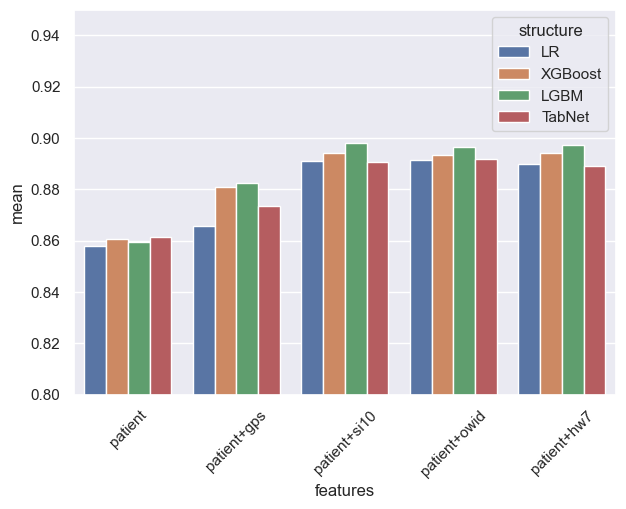

In [62]:
import seaborn as sns
sns.set_theme(style="darkgrid")

target_features = scall_features
sorterIndex = dict(zip(target_features, range(len(target_features))))

# Generate a rank column that will be used to sort
df_plot = df_scall[df_scall['features'].isin(target_features)]
df_plot['feature_index'] = df_plot['features'].map(sorterIndex)
df_plot = df_plot.sort_values('feature_index')
                   
# Create the bar plot.
plt.figure(figsize=(7,5))
sns.barplot(x="features", y="mean", hue="structure", data=df_plot)
plt.ylim(0.8, .95)
plt.xticks(rotation=45)

# Show the plot.
plt.show()